In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Documentation: `automin`

## Table of Contents
1. [Introduction](#introduction)
2. [How To Use AutoDiff](#how-to)
    - [Installing the Package](#installation)
    - [Demo](#demo)
2. [Background](#background)
4. [Software Organization](#SoftwareOrganization)
    - [Directory Structure](#structure)
    - [Modules](#modules)
    - [Test Suite](#tests)
    - [Distribution](#distribution)
    - [Installation](#installation)
5. [Implementation](#implementation)
    - [Core Data Structure](#p1)
    - [Major Class](#p2)
    - [Method and Name Attributes in autodiff Class](#p3)
    - [Other Functions](#p4)
    - [External Dependences](#p5)
6. [Future](#future)

<a id="introduction"></a>
## Introduction 

It goes without saying that taking derivatives is an essential operation in numerical methods, optimization, and science. From a computational perspective, however, calculating a derivative can be a difficult.

If one uses **finite differences** (i.e. $f'(x) \approx (f(x+\epsilon) - f(x))/\epsilon)$), one needs to choose $\epsilon$ appropriately. If $\epsilon$ is too large, the approximation is poor. If $\epsilon$ is too small, one introduces round-off errors.

Alternatively, if one uses **symbolic differentiation** (i.e. an algorithm that produces the derivative as a symbolic function), the problem becomes computationally infeasible when you either have functions with many inputs or want to take high order derivatives. These two scenarios occur often in applications.

**Automatic differentiation** overcomes these challenges by providing both quick and accurate derivatives.

<a id="how-to"></a>
## How To Use `automin`

<a id="installation"></a>
### Installing the Package
You can use pip to install the test `automin` package. 

```
pip install -i https://test.pypi.org/simple/ automin
```

<a id="demo"></a>
### Demo for Automatic Differentiation

To use the package, first import the `variables` and `AD_numpy` modules.

In [2]:
import automin.autodiff.variables as v
import automin.autodiff.AD_numpy as np

The core object in `automin` is the `Variable` class. They allow numbers to have both objects and derivatives.

In [3]:
# Initialize a variable with a name and a value
x = v.Variable('x', 3)
y = v.Variable('y', 4)

Functions of `Variable` instances return another `Variable`. Functions such as `sin` and `log` can be found in the `AD_numpy` module.

#### Scalar Function

In [4]:
f = x**2+y**2+np.sin(x)
print(f)

Variable name: f(y,x), Value: 25.14112000805987, Derivatives: {'y': 8, 'x': 5.010007503399555}


To return the partial derivatices, use the `partial_der` function

In [5]:
f.partial_der(x)

5.010007503399555

To return the jacobian, call the `jacobian` function

In [6]:
f.jacobian()

{'x': 5.010007503399555, 'y': 8}

#### Vector Function

We use `decorator` to make vector function more straightforward, and have the same usage as scalar function. 

To use this method, we first import `vector_variables`.

In [7]:
import automin.autodiff.vector_variables as vv
import numpy

In [8]:
@vv.vectorize_variable
def vec_fn(x, y, z):
    f1 = x * y + np.sin(y) + np.cos(z)
    f2 = x + y + np.sin(x*y)
    return numpy.array([f1,f2])

the user can extract the values, jacobian, and partial derivatives just like it is a scalar function.

In [9]:
z = v.Variable('z', 2)
res2 = vec_fn(x, y, z)

In [10]:
res2

f0: Variable name: f(y,z,x), Value: 10.82705066814493, Derivatives: {'y': 2.346356379136388, 'z': -0.9092974268256817, 'x': 4}
f1: Variable name: f(y,x), Value: 6.463427081999565, Derivatives: {'y': 3.5315618761974763, 'x': 4.375415834929969}

In [11]:
print('Value: {}.'.format(res2.val))
print('Partial Derivative wrt x: {}'.format(res2.partial_der(x)))
display(res2.jacobian())

Value: [10.82705067  6.46342708].
Partial Derivative wrt x: [4.         4.37541583]


,x,y,z
0,4.000000,2.346356,-0.909297
1,4.375416,3.531562,0.000000


### Demo for user defined function -- Newton's Method for root-finding 

We can directly use `op.get_gradient` method to get all the derivatives and solve users' need.

User can define any function, as long as it define variable names in a list of string input.

In [12]:
import automin.optimizer as op

In [13]:
# example for defining variable names
initial_x=[3,4] # this is a two-dimension variable inputs
var_names = ['x'+str(idx) for idx in range(len(initial_x))]

Use Newton's Method for root-finding as follows, we can see how simple and directly use our method to get gradient and satisfy users' need.

In [14]:
def newton_method_scalar(fn, x, threshold, max_iter, verbose=True, norm=2):
    
    var_names = ['x'+str(idx) for idx in range(len(x))]
    
    x = numpy.array(x)
    nums_iteration = 0
    while True:
        x_new = x - fn(*x) / op.get_gradient(fn, x, var_names)

        # print iteration output
        if verbose is True:
            print(f'Iteration at {nums_iteration}, at {x} ')
        
        # threshold stopping condition 
        if numpy.linalg.norm(x-x_new, norm) < threshold:
            print(f'After {nums_iteration} iterations, found a root: {x_new}')
            break
        
        # iteration stopping condition
        if nums_iteration >= max_iter:
            break
        nums_iteration +=1
        x = x_new


In [15]:
f2 = lambda x, y, z: (x-4)**2 + (y-3)**2 + (z-2)**2
newton_method_scalar(f2, [3, 2, 1], 1e-6, 50, verbose=True)

Iteration at 0, at [3 2 1] 
Iteration at 1, at [4.5 3.5 2.5] 
Iteration at 2, at [3.75 2.75 1.75] 
Iteration at 3, at [4.125 3.125 2.125] 
Iteration at 4, at [3.9375 2.9375 1.9375] 
Iteration at 5, at [4.03125 3.03125 2.03125] 
Iteration at 6, at [3.984375 2.984375 1.984375] 
Iteration at 7, at [4.0078125 3.0078125 2.0078125] 
Iteration at 8, at [3.99609375 2.99609375 1.99609375] 
Iteration at 9, at [4.00195312 3.00195312 2.00195312] 
Iteration at 10, at [3.99902344 2.99902344 1.99902344] 
Iteration at 11, at [4.00048828 3.00048828 2.00048828] 
Iteration at 12, at [3.99975586 2.99975586 1.99975586] 
Iteration at 13, at [4.00012207 3.00012207 2.00012207] 
Iteration at 14, at [3.99993896 2.99993896 1.99993896] 
Iteration at 15, at [4.00003052 3.00003052 2.00003052] 
Iteration at 16, at [3.99998474 2.99998474 1.99998474] 
Iteration at 17, at [4.00000763 3.00000763 2.00000763] 
Iteration at 18, at [3.99999619 2.99999619 1.99999619] 
Iteration at 19, at [4.00000191 3.00000191 2.00000191] 
I

Therefore, user can easily define any method they want using our `op.get_gradient` method.

<a id="demo"></a>
### Demo for Optimization

To use the package, first import the Optimizer module.

In [16]:
import automin.optimizer as op

Optimizer module has various methods for optimizations, such as min_conjugate_gradient, min_steepestgradient, and min_BFGS. 

In [17]:
print(dir(op))

['MAXITER', 'Model', 'NORM', 'PRECISION', 'Result', 'Variable', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_get_grad', 'get_gradient', 'min_BFGS', 'min_conjugate_gradient', 'min_gradientdescent', 'min_steepestdescent', 'minimize', 'minimize_over_data', 'np', 'os', 'sys', 'time', 'warnings']


Once choosing which optimization method to use, a user can initialize the function and its initial values.  We have four method to choose: 
1. Gradient Descent

2. Steepest Descent

3. Conjugate Gradient 

4. Broyden-Fletcher-Goldfarb-Shanno (BFGS) 

5. Stochastic Gradient Descent

To demonstrate the functionality of this package, here is a simple implementation of min_conjugate_gradient for $(x-4)^2+ (y-3)^2 + (z-2)^2$

In [18]:
# an example function
f = lambda x, y, z: (x-4)**2 + (y-3)**2 + (z-2)**2
res = op.minimize(f, [3, 0, 1], method='Steepest Descent', sigma=1e-6, max_iter=50)
res.x

array([4., 3., 2.])

The user can also access the value at each iteration

In [19]:
res.val_rec

array([[3., 0., 1.],
       [4., 3., 2.]])

... and how many time it cost at each iteration

In [20]:
res.time_rec

[0, 0.0009996891021728516]

### Demo for Evaluation of Optimization

To use the package, first import the Evaluate module.

In [21]:
import automin.evaluate as evaluate

Evaluate module has various methods for optimizations, such as plot_path, plot_convergency,plot_accuracy, show_accuracy

In [22]:
print(dir(evaluate))

['Variable', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'colors', 'minimize', 'np', 'plot_acc', 'plot_accuracy', 'plot_conv', 'plot_convergency', 'plot_path', 'plot_path_1D', 'plot_path_2D', 'plt', 'show_acc', 'sys']


We use Rosenbrock function to show path of different optimizer.

$F_1=100(y-x^2)^2+(1-x)^2$

In [23]:
# Rosenbrock function
f1=lambda x, y : 100*(y-x**2)**2 + (1-x)**2
# Initial Value lists
v0_list = [[-5,5], [5,5], [5,-5]]
# Model you want to use
models=['Conjugate Gradient','Steepest Descent','BFGS','Gradient Descent']
# Xlim and Ylim you want to show
import numpy
x_grid = numpy.linspace(-10, 10, 500)
y_grid = numpy.linspace(-10, 10, 500)

Run each model and store them in a dictionary.

In [24]:
res={}
for model in models:
    res[model]=[op.minimize(f1,v0,method=model,max_iter=100000,lr=1e-5,sigma=1e-5,precision=1e-5) for v0 in v0_list]

C:\Users\Lenovo\Desktop\cs207_FinalProject\automin\optimizer.py:36: UserWarning: optimization did not converge
  warnings.warn("optimization did not converge")


Show the path of each method

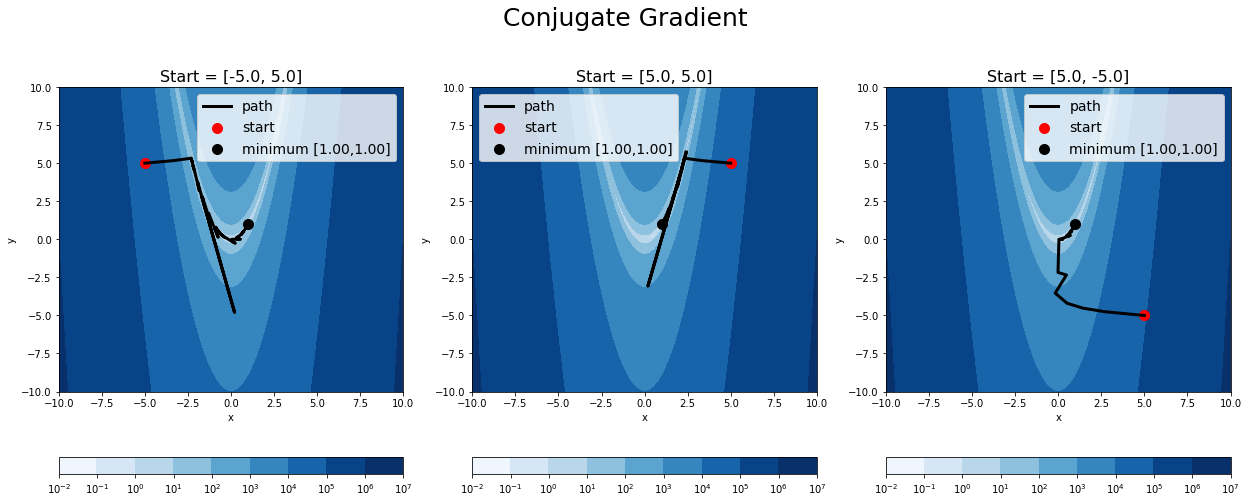

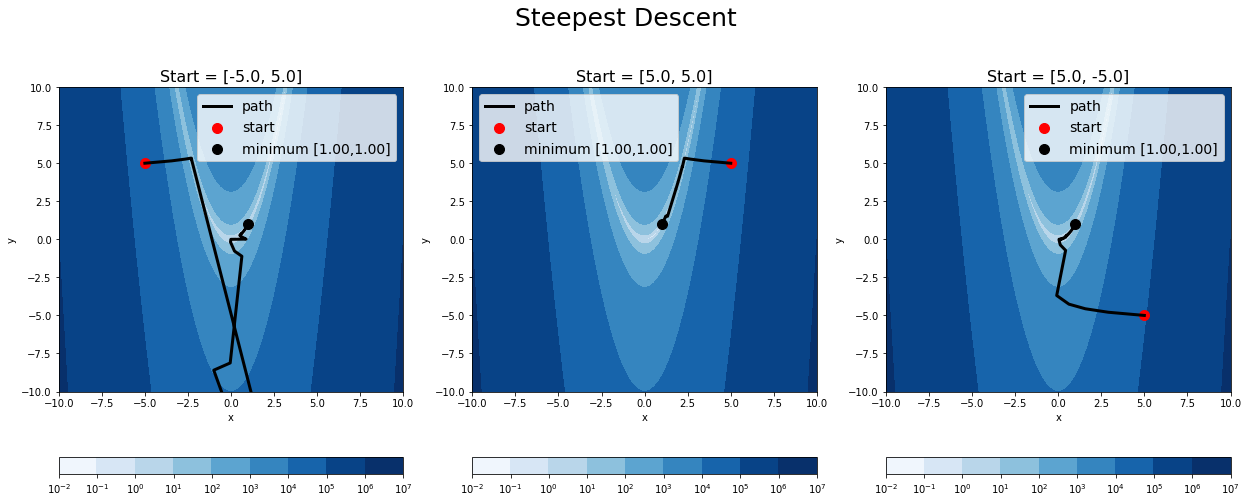

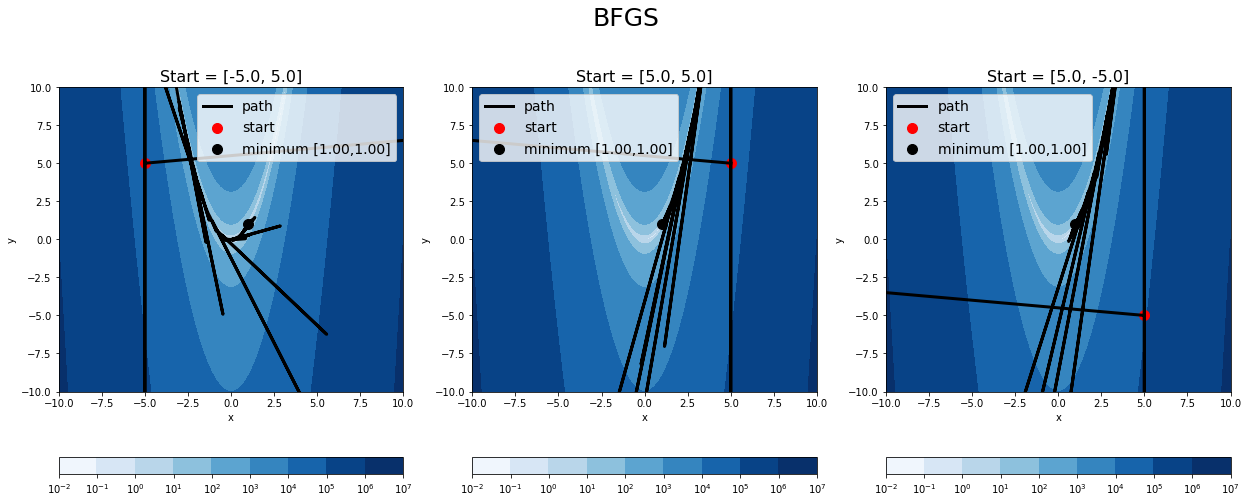

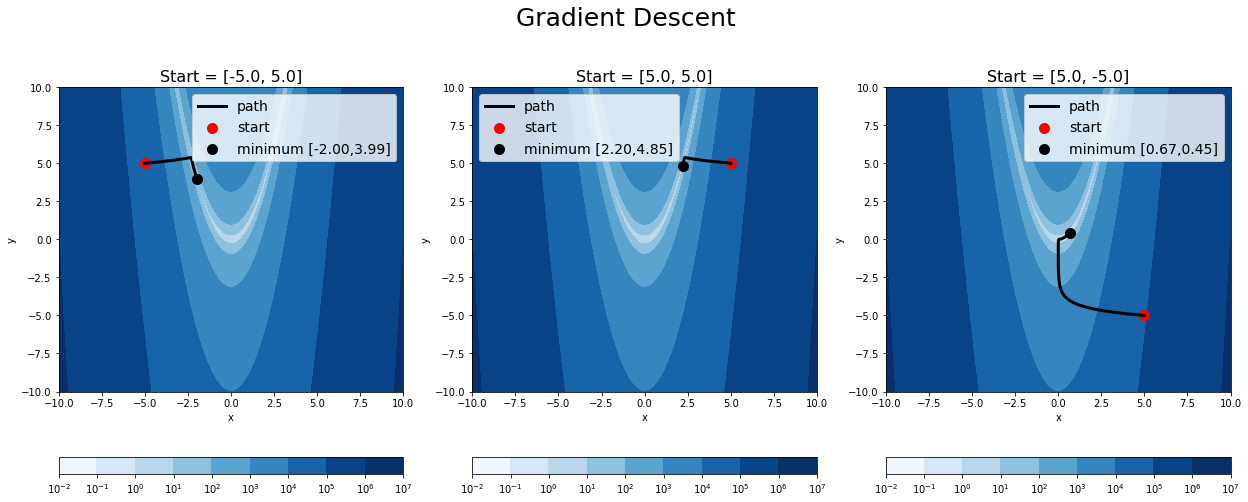

In [25]:
for model in models:
    evaluate.plot_path(f1, res[model], model, x_grid=x_grid, y_grid=y_grid)

Show the convergence plot and accuracy

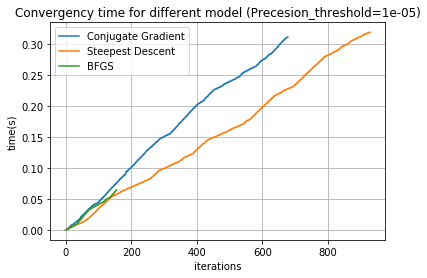

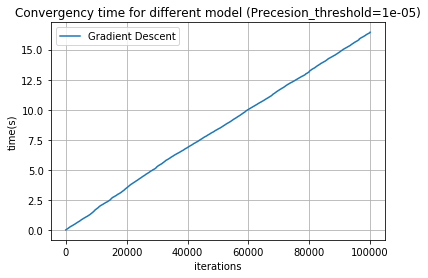

In [26]:
evaluate.plot_convergency(res,i=-1)

The line shows the total time ever since for each iterations. To better shows the results, we separately plot the convergent method and the method not converge.

Clearly, BFGS converges fastest, Conjugate Gradient comes next, and then Steepest Descent. The slowest one is Gradient Descent, and we can show through our package, that gradient descent is sensitive to the starting point as well as learning rate.

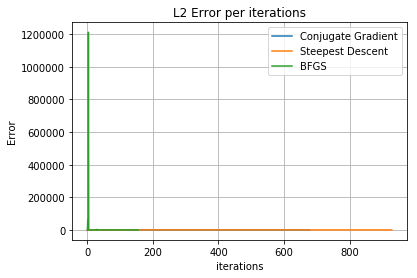

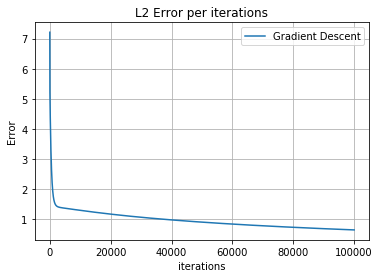

In [27]:
evaluate.plot_accuracy(res,[1,1],i=-1)

Through this plot, we have a deep impression that how BFGS moves so messy and cause high error for the first few steps, but it converges fastest and reaches lowest error.

### Compare our methods with `scipy.optimization.minimize`

Import `scipy` package and run the same function.

In [28]:
from scipy.optimize import minimize 
for model in ['BFGS','CG']:
    res['scipy_'+model]=[minimize(lambda x:f1(*x),v0,method=model) for v0 in v0_list]

Use our evaluation method to show the accuracy rate.

In [29]:
val,labels=[],[]
for k,v in res.items():
    if 'scipy_' in k:
        val.append(v[0].x)
        labels.append(k)
    else:
        if v[0].converge:
            val.append(v[0].x)
            labels.append(k)
evaluate.show_acc(val,[1,1],labels)

L2 error for Conjugate Gradient   is: 2.35E-05
L2 error for Steepest Descent     is: 2.43E-05
L2 error for BFGS                 is: 5.21E-07
L2 error for scipy_BFGS           is: 7.87E-06
L2 error for scipy_CG             is: 5.04E-06


Looks, `scipy` method reaches $1e^{-6}$ precision rate, but our method of `BFGS` reaches $1e^{-7}$.

<a name="background"></a>
## Background

Automatic differentiation computes derivatives recursively using the chain rule. All functions are either an **"elementary" function**, for which we know the derivative, or a composition of elementary functions. To calculate the derivative of a composite function $f(g(x))$, we apply the chain rule as follows:

$$
\frac{df}{dx} = \frac{df}{dg}\frac{dg}{dx}
$$

The chain rule can be applied recursively, which we exploit in automatic differentiation. For example, if we have a complex composite function $f(g(h(x)))$, we can compute f'(x) by first calculating

$$
\frac{dg}{dx} = \frac{dg}{dh}\frac{dh}{dx}
$$

and then plugging this derivative into 

$$
\frac{df}{dx} = \frac{df}{dg}\frac{dg}{dx}
$$

This is in fact a simple example of **forward-mode** automatic differentiation. In general, to conduct forward mode automatic differentiation, we represent our function to differentiate as a **computational graph**. The computational graph  captures the inputs and outputs of our elementary functions. In an example that can be found [here](http://www.columbia.edu/~ahd2125/post/2015/12/5/), we can represent $f(x,y)=\cos(x)\sin(y)+\frac{x}{y}$ as 

![comp-graph](figs/comp_graph_background.png)

By computing derivatives recursively using the chain rule from the inputs $x$ and $y$ to the output $f$, we can calculate the derivative over the entire graph.

This project will implement only forward-mode automatic differentiation, but as an aside, **reverse-mode automatic differentiation** begins at the output(s) of the computational graph and calculates derivates using the chain rule by traversing the graph backwards.

In terms of optimization, we implemented advanced gradient-based optimization methods such as conjugate gradient, steepest descent, and BFGS and the basic gradient descent, in order to fully utilize properties of our automatic differentiation package. The general idea to use forward-mode automatic differentiation to find out the minimum of a function in different ways. Given initial values and a sample function, 
initial values are updated in every iteration based on the different optimization methods, slowly moving toward the mininum value. 

For example, an illustration below shows how steepest descent and conjugate gradient find optimum by updating the functionfor each step. Details of algorithms are discussed in our optimization package, with appropriate examples in test files. 

![descent.png](figs/descent.png)

<a name="SoftwareOrganization"></a>
## Software Organization

<a name="structure"></a>
### Directory Structure

The directory structure will be as follows

```
|-- README.md  
|-- __init__.py  
|-- automin  
|   |-- __init__.py  
|   |-- autodiff  
|   |   |-- __init__.py  
|   |   |-- AD_numpy.py  
|   |   |-- variables.py
|   |   |-- vector_variables.py
|   |-- evaluate.py
|   |-- optimizer.py
|-- demos
│   |-- test_for_optimizer.ipynb
|-- docs
│   |-- Final.ipynb
│   |-- milestone1.ipynb
│   |-- milestone2.ipynb
│   |-- presentation_slides.ipynb
|-- requirements.txt
|-- setup.py
|-- tests
|   |-- __init__.py
|   |-- test_numpy.py
|   |-- test_optimizer.py
|   |-- test_variables.py
```

<a name="modules"></a>
### Modules

The `variables` module contains the functionality to define variables that are compatible with automatic differentiation. These variables will be passed to functions in `AD_numpy` or to functions specified by the user with `unary_user_function` or `binary_user_function`.

The `AD_numpy` module stores our mathematical functions that will overwrite the typically used numpy package such that the user can use mathematical functions on Variable instances just as they would with numeric values. 

The `vector_variables` module contains the functionality to wrap vector-valued functions to make them compatible with the Variable instances. This will allow the user to extract the value and jacobian of these vector-valued functions.

The `optimizer` module introduces various optimization methods implemented based on the `variables` module and the `AD_numpy` module. Each optimization method has function, initial values, type of norm to use, and the precision and maximum number of iterations that determine the stopping point as arguments. 

<a name="tests"></a>
### Test Suite

We will store our tests in the `tests` module and run them using `TravisCI`.

<a name="distribution"></a>
### Distribution 

The package is distributed on `PyPI`. 

<a name="installation"></a>

### Installation

You can use pip to install the test `automin` package with the following command.

```
pip install automin
```


<a name="implementation"></a>
## Implementation 
<a id="p1"></a>

### Major data structure: Variables and the Computational Graph

Our variables will be the nodes in our computational graph. The variables will keep track of the node's value and it's derivative.

<a id="p2"></a>
### Classes

The main class that we will implement is the `Variable` class. All auto-differentiable functions will have inputs and outputs consisting of instances of the `Variable` class. The `Variable` class will be an extension on ordinary python numbers. It will store the derivative of the variable and it's actual value. The `vector_Variable` class extends upon the `Variable` class to allow for users to apply vector-valued functions on the `Variable` class through a simple wrapper function `vectorize_variable`. 

In addition, as a main functionality of our package is to allow for basic optimization that comes with ready-made visualizations, the package comes with a `Result` class that stores the key information of an optimization. These are compatible with our optimization visualization and may also be accessed by the user for their own use. 

Finally, we've implemented a `Model` class, that one needs to extend to access `stochastic gradient descent`.

<a id="p3"></a>
### Attributes and Methods in Variable Class
* Attributes

The `Variable` class will have three main instance attributes, the name, the value, and the derivative of the variable instance.

`Variable.name`: name of the variable. When the user first instantiates a `Variable` instance, it is important that the user sets the name of the variable. This is necessary to keep track of the various variables while we calculate compound functions. Importantly, this will allow us to calculate the partial derivatives with respect to each of the instantiated `Variable` instances correctly.

`Variable.val`: value of the variables. The shape is the same as the input variable. 

`Variable.der`: value of the derivatives. The derivatives are held in a dictionary, with each key corresponding to the names of base Variable instances that we instantiated. The corresponding value pair is the partial derivative of the function with respect to the key.

* Dunder Methods

In order to override the four basic operations of elementary arithmetic (addition, subtraction, multiplication, and division), we use dunder methods within our `Variable` class. The dunder methods return new `Variable` instances with the updated value and derivatives. We also override the power and negation operations. In addition, we included the equality dunder method (and non-equality method) to allow the user to verify if two Variable instances are equal. They are equal if they share both the same value and Jacobian. 

* Methods

The two main methods that the user will typically use are `Variable.jacobian()` and `Variable.partial_der(x)`. The former returns the jacobian of the function that the user calcluated from `Variable` instances. The latter returns the partial derivative with respect to a specific `Variable` instance. It will throw an error if the specific `Variable` instance is not defined or not present within the function.

<a id="p3"></a>
### Attributes and Methods in vector_Variable Class
* Attributes

The `vector_Variable` class has three main instance attributes, the original vector of Variables, and the value and jacobian of the vector function.

`vector_Variable.variables`: the original vector of Variables.

`vector_Variable.val`: value of the vector function. This is an array that is basically the output of the vector function without using the Variable class.

`vector_Variable.der`: jacobian of the vector function. This is stored in a pandas dataframe to allow the user to identify with Variable each value in the jacobian matrix is calculated with respect to. This can easily be transformed to an array with .values

* Dunder methods

Similar to the basic `Variable` class, we override the four basic operations of elementary arithmetic with dunder methods within our `vector_Variable` class.

* Methods

Similar to the basic `vector_Variable` class, the two main methods that the user will typically use are `vector_Variable.jacobian()` and `vector_Variable.partial_der(x)`. They work similarly as in the `Variable` class. This ensures that our functions are consistent across both Variable classes, making it more intuitive for users.

<a id="p4"></a>
### Attributes in Result Class
* Attributes

The `Result` class is a simple storage class that stores 4 main attributes.

`Result.x`: the value that minimizes the function if the optimizer converges, else the last recorded value before the optimizer terminates due to it reaching the maximum number of iterations

`Result.val_rec`: an array storing the history of values for the optimizer that stores a value for each iteration of the chosen algorithm

`Result.time_rec`: an array storing the history of time taken for each iteration of the chosen algorithm

`Result.converge`: a boolean indicating whether the chosen algorithm converged, thus letting the user know if the value stored in `Result.x` is the value that minimizes the function

<a id="p4.5"></a>
### Attributes in Model Class

To use the `Model` class one needs to implement a `predict` method and a `loss` method. Each function takes parameters as inputs and accesses the data as `self.data`. To initialize this class, simply pass your data as a `pandas dataframe` to the constructor.

<a id="p5"></a>
### Mathematical functions

* Define elementary differentiation function. 

In order to deal with the other elementary functions (exponential, logarithm, powers, roots, trigonometric functions, inverse trigonometric functions, hyperbolic functions, etc.), we will override the numpy elementary functions such that we can use it for our AutoDiff class. 

>For example, we will override the `np.sin` function such that if you use it on an `Variable` instance `x` at a given value, it will return another `Variable` instance with the value of $\sin(x)$, and the calculated derivative of $\dot{x}\cos(x)$ at the given value. Similarly, we will override the `np.exp` function such that if you use it on an `Variable` instance `x` at a given value, it will return another `Variable` instance with the value of $\exp(x)$, and the calculated derivative of $\dot{x}\exp(x)$ at the given value.

<a id="p6"></a>
### Optimizer functions 

We introduce 5 main algorithms for optimization: gradient descent, steepest descent, conjugate gradient, Broyden-Fletcher-Goldfarb-Shanno (BFGS), and stochastic gradient descent optimization methods. The user interacts with a `minimize` function and is able to call upon any of the 4 methods. The result of the optimizer is stored in a `Result` class. The user can then call methods on the `Result` class to make some simple visualization plots easily. 

<a id="p7"></a>
### User defined functions

All the mathematical functions that come with our `autoder` package are implemented with two user-defined functions, one for unary functions, one for binary functions. These two functions not only allow us to streamline future updates for our mathematical functions, but also allow anyone using the package to define their own mathematical functions easily. We believe this is a neat addition that can simplify the work for our users. 

The user might have to reuse a specific complex function several times in their work. They can now implement it as a single function that can be applied to our Variable class easily. A simple example is the secant function. The secant function is just the reciprocal of the sine function, and as such, the user can easily use our sine function for their calculations. However, the user can also create a secant function for their usage as well. 

```python
>>> sec = lambda x: 1/np.cos(x)
>>> sec_der = lambda x: sec(x)*np.tan(x)
>>> ad_sec = unary_user_function(sec, sec_der)
>>> a = Variable('a', 2)
>>> x = ad_sec(a)
>>> x.val
-2.4029979617223809
>>> x.jacobian()
5.25064633769958
```

<a id="p7"></a>
### External dependencies 

The main and only external dependency for our package is the external numpy package. This will be specified in our setup.py file as a dependency that should be installed together with our package. The external numpy package is necessary for our the various mathematical operations necessary for Automatic Differentiation.


<a name="future"></a>
## Future
<a id="p1"></a>

Our `automin` package allows the user to work with scalar with single inputs and vector functions of multiple inputs. We have also included a basic functionality for the user to work with vector-valued functions and extract the jacobian of the vector of such functions easily. We would like to eventually expand upon these vector-valued functions to allow users to also extract the Hessian of the jacobian matrices, and perhaps even 2nd order derivatives. This will allow us to expand the optimization methods in our package to include methods such as Newton's method, Quasi-Newton's method, etc.

A related future update could also allow users to work with matrix calculus, which has applications in calculating gradients of complex deep learning networks for loss minimzation. Matrix calculus also has substantial applications in statistics and econometrics, such as with regard to the analysis of multivariate normal, or generally, elliptical contoured distributions. Matrix calculus could also be useful in mixture models, such as when one is trying to use an Expectation-Maximization algorithm to analyze Gaussian Mixture Models.